In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from datasets import load_from_disk

/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [2]:
#DATASET = 'CelebA_male_Smiling'
DATASET = 'CelebA_drift_simulated_with_Male_Wearing_Earrings'

dataset = load_from_disk(f"data/CelebA/{DATASET}")

# Select the first 100.000 sample to save ram
dataset["historical_train"] = dataset["historical_train"]#.select(range(10000))

num_train = dataset["historical_train"].num_rows
num_validation = dataset["historical_test"].num_rows
num_test = dataset["datastream_no_drift"].num_rows
num_test_drift = dataset["datastream_drift"].num_rows

In [3]:
print("Train split (historical_train):{}, \n"
      "Validation split (historical_test):{}, \n"
      "Test split (datastream_no_drift):{}, \n"
      "Test split (datastream_drift):{}".format(num_train, num_validation, num_test, num_test_drift))

Train split (historical_train):155951, 
Validation split (historical_test):19114, 
Test split (datastream_no_drift):19076, 
Test split (datastream_drift):1349


In [4]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = 1. if item['Male'] else 0.
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [5]:
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Dataloaders

In [6]:
BATCH_SIZE = 64

# Datasets
train_dataset = HFDatasetWrapper(dataset['historical_train'], transform=eval_transform)
val_dataset = HFDatasetWrapper(dataset['historical_test'], transform=eval_transform)
test_dataset = HFDatasetWrapper(dataset['datastream_no_drift'], transform=eval_transform)
test_dataset_drift = HFDatasetWrapper(dataset['datastream_drift'], transform=eval_transform)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

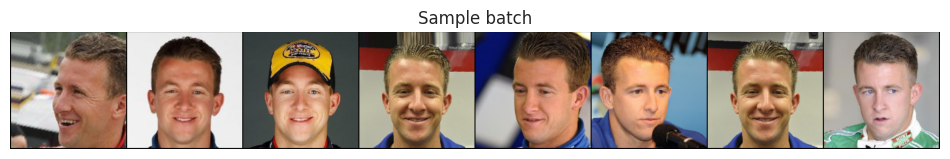

In [7]:
images, labels, _ = next(iter(train_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.show()

### Binary concept presence table (training set)

In [8]:
from datasets import Value

attribute_columns = [attr for attr in dataset['historical_train'].features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift', 'Male']]

train_concept_presence = dataset['historical_train'].select_columns(attribute_columns)

# cast to float
for col in train_concept_presence.column_names:
    if train_concept_presence.features[col].dtype == "bool":
        train_concept_presence = train_concept_presence.cast_column(col, Value(dtype="float"))

train_concept_presence = train_concept_presence.to_pandas()
train_concept_presence

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155947,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
155948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
# Extract Concept presence table for test set (drift / no drift)
test_nodrift_concept_presence = dataset['datastream_no_drift'].select_columns(attribute_columns)
test_drift_concept_presence = dataset['datastream_drift'].select_columns(attribute_columns)

# cast to float
for col in test_nodrift_concept_presence.column_names:
    if test_nodrift_concept_presence.features[col].dtype == "bool":
        test_nodrift_concept_presence = test_nodrift_concept_presence.cast_column(col, Value(dtype="float"))

for col in test_drift_concept_presence.column_names:
    if test_drift_concept_presence.features[col].dtype == "bool":
        test_drift_concept_presence = test_drift_concept_presence.cast_column(col, Value(dtype="float"))


test_nodrift_concept_presence = test_nodrift_concept_presence.to_pandas()
test_drift_concept_presence = test_drift_concept_presence.to_pandas()
test_drift_concept_presence

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1345,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1346,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1347,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Mean concept presence: 0.22171691338288538


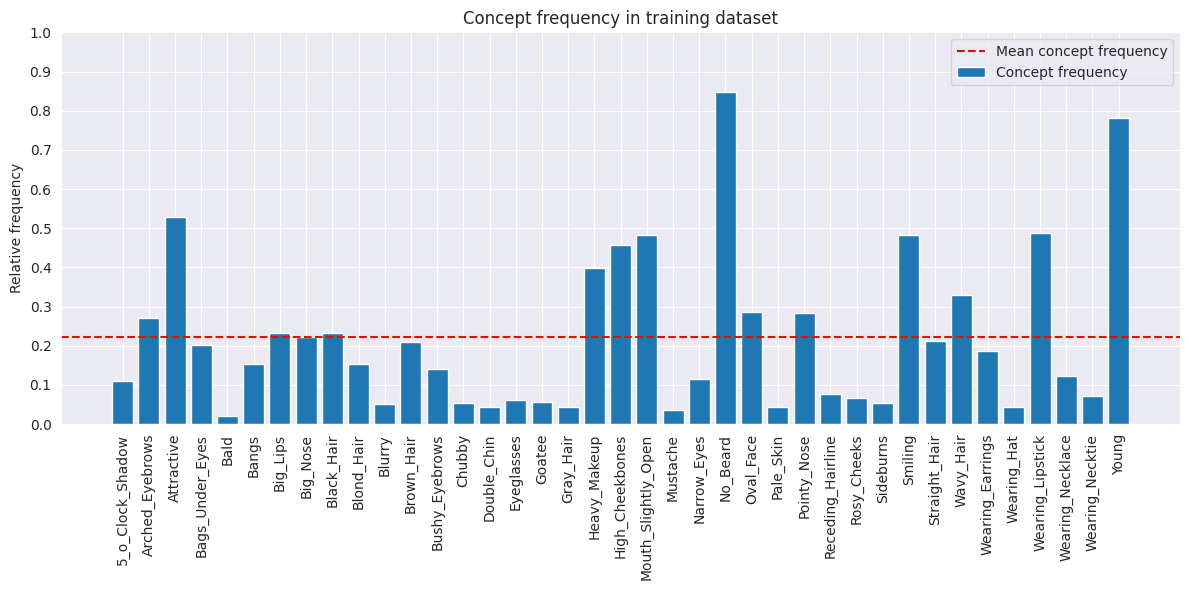

In [10]:
concept_freq = {
    col: sum(train_concept_presence[col])/len(train_concept_presence) for col in train_concept_presence.columns
}

mean_concept_freq = np.mean(list(concept_freq.values()))
print(f'Mean concept presence: {mean_concept_freq}')

plt.figure(figsize=(12,6))
plt.bar(train_concept_presence.columns, concept_freq.values(), label='Concept frequency')
plt.axhline(mean_concept_freq, color='red', linestyle='--', label='Mean concept frequency')
plt.ylabel('Relative frequency')
plt.title('Concept frequency in training dataset')
plt.xticks(train_concept_presence.columns, rotation=90)
plt.yticks(np.arange(0.,1.1,0.1))
plt.legend()
plt.tight_layout()
plt.savefig('concept_freq.pdf')

In [11]:
# Find percentiles for each attribute (to use for kernel binarization)
train_concept_percentiles = {c: int(100 * train_concept_presence[c].eq(0.0).sum() / len(train_concept_presence[c])) for c in train_concept_presence.columns}
train_concept_percentiles

{'5_o_Clock_Shadow': 89,
 'Arched_Eyebrows': 72,
 'Attractive': 47,
 'Bags_Under_Eyes': 79,
 'Bald': 97,
 'Bangs': 84,
 'Big_Lips': 76,
 'Big_Nose': 77,
 'Black_Hair': 76,
 'Blond_Hair': 84,
 'Blurry': 94,
 'Brown_Hair': 79,
 'Bushy_Eyebrows': 85,
 'Chubby': 94,
 'Double_Chin': 95,
 'Eyeglasses': 93,
 'Goatee': 94,
 'Gray_Hair': 95,
 'Heavy_Makeup': 60,
 'High_Cheekbones': 54,
 'Mouth_Slightly_Open': 51,
 'Mustache': 96,
 'Narrow_Eyes': 88,
 'No_Beard': 15,
 'Oval_Face': 71,
 'Pale_Skin': 95,
 'Pointy_Nose': 71,
 'Receding_Hairline': 92,
 'Rosy_Cheeks': 93,
 'Sideburns': 94,
 'Smiling': 51,
 'Straight_Hair': 78,
 'Wavy_Hair': 67,
 'Wearing_Earrings': 81,
 'Wearing_Hat': 95,
 'Wearing_Lipstick': 51,
 'Wearing_Necklace': 87,
 'Wearing_Necktie': 92,
 'Young': 21}

### Load model

In [12]:
CNN = 'ResNet-50' # 'ResNet-50' or 'VGG-16'

USE_ALL_RESIDUAL_FEATURES = False # if False use feature-maps from last conv layer

NUM_CLASSES = 1      # Gender classification (1 for binary classification)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


net = resnet50() # Loading ResNet-50 model (pretrained on ImageNet)
net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50

# Load pre-trained net
net.load_state_dict(torch.load(f'./weights/{CNN}-{DATASET}.pth', weights_only=True))
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Extract CNN encoder

In [13]:
if USE_ALL_RESIDUAL_FEATURES:
    encoder_1 = torch.nn.Sequential(*list(net.children())[:-5]).to(DEVICE)
    encoder_2 = torch.nn.Sequential(*list(net.children())[:-4]).to(DEVICE)
    encoder_3 = torch.nn.Sequential(*list(net.children())[:-3]).to(DEVICE)

encoder = torch.nn.Sequential(*list(net.children())[:-2]).to(DEVICE)
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [14]:
# Check encoder output shape
x = torch.randn(1,3,224,224).to(DEVICE)

with torch.no_grad():
    if USE_ALL_RESIDUAL_FEATURES:
        y_1 = encoder_1(x)
        y_2 = encoder_2(x)
        y_3 = encoder_3(x)

    y = encoder(x)

if USE_ALL_RESIDUAL_FEATURES:
    print(y_1.shape)
    print(y_2.shape)
    print(y_3.shape)

print(y.shape)

torch.Size([1, 2048, 7, 7])


### Create ERIC for Symbolic Rule Extraction

In [15]:
from eric_extractor_2 import ERICExtractor

eric = ERICExtractor(encoder, num_classes=NUM_CLASSES)

### Process training and test set (compute kernel norms)

In [16]:
#feature_maps_list = []
kernel_norms_list = []
labels_list = []
predictions_list = []
sample_count = 0

net.to(DEVICE)
net.eval()
encoder.eval()

if USE_ALL_RESIDUAL_FEATURES:
    encoder_1.eval()
    encoder_2.eval()
    encoder_3.eval()

with torch.no_grad():
    for images, labels, _ in tqdm(train_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Extract CNN feature maps (last layer)
        feature_maps = encoder(images)

        # Get CNN predictions
        outputs = net(images)
        preds = (torch.sigmoid(outputs.squeeze(1)) >= 0.5).float()

        # Calculate kernel norms for ERIC
        kernel_norms = eric.compute_kernel_norms(feature_maps)

        # Store results
        #feature_maps_list.append(feature_maps.cpu())
        kernel_norms_list.append(kernel_norms.cpu())
        labels_list.append(labels.cpu())
        predictions_list.append(preds.cpu())

        sample_count += images.shape[0]

        if USE_ALL_RESIDUAL_FEATURES:
            # Extract CNN feature maps (previous layers)
            feature_maps = encoder_1(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_2(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_3(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            kernel_norms_list.append(kernel_norms.cpu())


#assert sample_count == len(train_dataloader)
#print((kernel_norms_list[0][0]))
#torch.cat(kernel_norms_list).shape
#predictions_list


100%|██████████| 2437/2437 [03:47<00:00, 10.70it/s]


In [17]:
#test_feature_maps_list = []
test_kernel_norms_list = []
test_labels_list = []
test_predictions_list = []
test_sample_count = 0

net.to(DEVICE)
net.eval()
encoder.eval()

if USE_ALL_RESIDUAL_FEATURES:
    encoder_1.eval()
    encoder_2.eval()
    encoder_3.eval()

with torch.no_grad():
    for images, labels, _ in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Extract CNN feature maps (last layer)
        feature_maps = encoder(images)

        # Get CNN predictions
        outputs = net(images)
        preds = (torch.sigmoid(outputs.squeeze(1)) >= 0.5).float()

        # Calculate kernel norms for ERIC
        kernel_norms = eric.compute_kernel_norms(feature_maps)

        # Store results
        #test_feature_maps_list.append(feature_maps.cpu())
        test_kernel_norms_list.append(kernel_norms.cpu())
        test_labels_list.append(labels.cpu())
        test_predictions_list.append(preds.cpu())

        test_sample_count += images.shape[0]

        if USE_ALL_RESIDUAL_FEATURES:
            # Extract CNN feature maps (previous layers)
            feature_maps = encoder_1(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_2(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_3(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_kernel_norms_list.append(kernel_norms.cpu())


100%|██████████| 299/299 [00:28<00:00, 10.47it/s]


In [18]:
#test_feature_maps_list = []
test_drift_kernel_norms_list = []
test_drift_labels_list = []
test_drift_predictions_list = []
test_drift_sample_count = 0

net.to(DEVICE)
net.eval()
encoder.eval()

if USE_ALL_RESIDUAL_FEATURES:
    encoder_1.eval()
    encoder_2.eval()
    encoder_3.eval()

with torch.no_grad():
    for images, labels, _ in tqdm(test_dataloader_drift):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Extract CNN feature maps (last layer)
        feature_maps = encoder(images)

        # Get CNN predictions
        outputs = net(images)
        preds = (torch.sigmoid(outputs.squeeze(1)) >= 0.5).float()

        # Calculate kernel norms for ERIC
        kernel_norms = eric.compute_kernel_norms(feature_maps)

        # Store results
        #test_feature_maps_list.append(feature_maps.cpu())
        test_drift_kernel_norms_list.append(kernel_norms.cpu())
        test_drift_labels_list.append(labels.cpu())
        test_drift_predictions_list.append(preds.cpu())

        test_drift_sample_count += images.shape[0]

        if USE_ALL_RESIDUAL_FEATURES:
            # Extract CNN feature maps (previous layers)
            feature_maps = encoder_1(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_drift_kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_2(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_drift_kernel_norms_list.append(kernel_norms.cpu())

            feature_maps = encoder_3(images)
            kernel_norms = eric.compute_kernel_norms(feature_maps)
            test_drift_kernel_norms_list.append(kernel_norms.cpu())

100%|██████████| 22/22 [00:02<00:00,  8.95it/s]


### Concepts naming

In [19]:
from scipy.stats import pointbiserialr

def _label_kernel_2(kernel_norms_list, train_concept_presence):
    # Prepare data
    all_kernel_norms = torch.cat(kernel_norms_list, dim=0)
    #all_binary_activations = eric.binarize_kernel_activations(all_kernel_norms)

    df_activations = pd.DataFrame(all_kernel_norms.numpy())

    df1 = df_activations         # continuous random variable
    df2 = train_concept_presence # binary random variable

    # Compute full correlation matrix
    corr_matrix = pd.DataFrame(
        {
            #col1: [df1[col1].corr(df2[col2]) for col2 in df2.columns]
            col1: [pointbiserialr(df2[col2], df1[col1])[0] for col2 in df2.columns]
            for col1 in df1.columns
        },
        index=df2.columns
    )

    # Find Top-1 Concept-Kernel correlated
    df = copy.deepcopy(corr_matrix) #df_kernel_concepts
    concept_naming_dict = {}

    for _ in range(len(corr_matrix.index)):
        concept, kernel = df.stack().idxmax()
        corr_value = df.loc[concept][kernel]
        #min_concept, min_kernel = df.stack().idxmin()
        concept_naming_dict[concept] = (kernel, corr_value)
        df.drop(index=concept, columns=kernel, inplace=True)

    #all_binary_activations = eric.binarize_kernel_activations(all_kernel_norms)
    #df_binary_activations = pd.DataFrame(all_binary_activations.numpy())

    return concept_naming_dict, corr_matrix #, df_binary_activations

In [20]:
# Kernel concepts labelling
print("Labelling kernels...")
#df_kernel_concepts, corr_matrix, df_binary_activations = _label_kernel_2(kernel_norms_list, train_concept_presence)
df_kernel_concepts, corr_matrix = _label_kernel_2(kernel_norms_list, train_concept_presence)

# Get kernel-concepts mapping
kernel_concept_mapping = {v[0]: k for k, v in df_kernel_concepts.items()}
concept_kernel_mapping = {k: v[0] for k, v in df_kernel_concepts.items()}
kernel_concept_mapping

Labelling kernels...


{905: 'Wearing_Lipstick',
 1765: 'Heavy_Makeup',
 13: 'No_Beard',
 707: '5_o_Clock_Shadow',
 1777: 'Arched_Eyebrows',
 1742: 'Attractive',
 1254: 'Blond_Hair',
 205: 'Wearing_Earrings',
 343: 'Wearing_Necktie',
 24: 'Wavy_Hair',
 1305: 'Sideburns',
 210: 'Big_Nose',
 604: 'Goatee',
 91: 'Young',
 1184: 'Bags_Under_Eyes',
 1439: 'High_Cheekbones',
 126: 'Bushy_Eyebrows',
 1957: 'Wearing_Necklace',
 1569: 'Rosy_Cheeks',
 966: 'Mustache',
 776: 'Pointy_Nose',
 1022: 'Eyeglasses',
 1824: 'Smiling',
 274: 'Chubby',
 66: 'Black_Hair',
 1201: 'Double_Chin',
 877: 'Gray_Hair',
 1008: 'Big_Lips',
 1878: 'Bangs',
 733: 'Wearing_Hat',
 1287: 'Brown_Hair',
 419: 'Bald',
 1056: 'Oval_Face',
 114: 'Mouth_Slightly_Open',
 158: 'Receding_Hairline',
 1480: 'Straight_Hair',
 407: 'Pale_Skin',
 468: 'Blurry',
 1598: 'Narrow_Eyes'}

In [21]:
# Select top predictors
cols = [v[0] for k, v in df_kernel_concepts.items()]

all_kernel_norms = torch.cat(kernel_norms_list, dim=0)
top_norm_predictors = pd.DataFrame(all_kernel_norms.numpy()).loc[:,cols]
top_norm_predictors

,905,1765,13,707,1777,1742,1254,205,343,24,...,733,1287,419,1056,114,158,1480,407,468,1598
0,6.721800,11.150925,16.301231,64.395836,10.032771,16.518713,27.545980,4.625655,53.786514,6.417818,...,25.106113,23.682177,33.017242,9.798088,19.308437,26.717386,31.493189,23.720057,25.547915,25.136892
1,3.386827,8.142682,10.740264,121.265518,3.113533,6.316864,23.788368,4.038212,97.594559,1.961584,...,17.730648,23.673101,37.683949,15.853695,6.909282,25.256096,57.830097,23.831684,16.318176,18.164944
2,3.206966,8.563248,13.196926,82.988457,9.256355,16.451546,23.815876,4.110665,57.958996,5.567874,...,19.374535,18.348587,31.660023,8.785053,21.560635,26.311516,33.187302,21.545540,23.650051,20.314453
3,2.078961,4.938908,12.577751,104.736801,10.979123,19.617788,24.642382,2.314995,73.124756,2.787949,...,18.054792,19.259069,38.983990,9.805387,23.930605,26.930676,42.105564,18.555836,24.305676,19.057751
4,2.777281,4.797446,15.181492,110.033943,5.515257,9.617910,23.054806,3.815127,77.977432,3.376417,...,20.573959,19.090075,37.744537,4.776835,14.869678,25.891117,39.786304,24.925701,23.563515,19.836596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,43.136406,32.874096,28.884682,6.518413,46.168602,39.684692,37.096790,33.025677,3.378621,59.073280,...,20.992983,29.095673,18.149311,31.507389,23.651098,12.532911,15.120033,25.591290,27.996937,16.916553
155947,57.412544,43.653091,26.281319,9.566363,68.220886,59.733593,33.240280,45.401459,6.084170,71.059410,...,15.849945,38.608665,19.026176,44.719978,32.710075,12.234435,18.824261,26.131306,24.793470,17.279224
155948,50.402161,36.789165,25.913811,5.764849,62.582840,49.629097,32.668594,37.084949,8.181620,66.694504,...,17.238882,34.439568,19.564787,35.145847,27.421547,11.989265,14.063557,28.986170,27.003208,20.033825
155949,58.497448,41.771339,26.676456,5.090184,61.804146,50.592140,39.910927,37.631538,2.206908,62.355766,...,17.113863,33.853638,14.780440,42.740257,24.405579,11.329790,19.495279,28.381912,24.605951,19.530865


In [22]:
# Rename column and order them according to train concept percentiles table
top_norm_predictors_named = top_norm_predictors.rename(columns=kernel_concept_mapping, inplace=False)[list(train_concept_percentiles.keys())]
top_norm_predictors_named

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,64.395836,10.032771,16.518713,27.142418,33.017242,25.891930,4.222714,36.451637,25.913195,27.545980,...,36.621849,25.218250,31.493189,6.417818,4.625655,25.106113,6.721800,7.750600,53.786514,10.316895
1,121.265518,3.113533,6.316864,37.710655,37.683949,18.497433,1.801548,48.933956,19.832222,23.788368,...,57.380993,29.323404,57.830097,1.961584,4.038212,17.730648,3.386827,4.716450,97.594559,12.439225
2,82.988457,9.256355,16.451546,24.569824,31.660023,22.223236,1.353760,34.867085,28.431339,23.815876,...,34.214188,22.524506,33.187302,5.567874,4.110665,19.374535,3.206966,6.545321,57.958996,7.510818
3,104.736801,10.979123,19.617788,35.859943,38.983990,19.216995,1.886222,40.131947,24.940432,24.642382,...,46.850349,30.803619,42.105564,2.787949,2.314995,18.054792,2.078961,4.456322,73.124756,11.327882
4,110.033943,5.515257,9.617910,30.565315,37.744537,18.350168,4.352943,43.167351,23.143812,23.054806,...,47.926678,28.840919,39.786304,3.376417,3.815127,20.573959,2.777281,6.445631,77.977432,8.310040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,6.518413,46.168602,39.684692,13.893944,18.149311,34.933739,43.939819,10.274424,21.769371,37.096790,...,10.785712,25.618450,15.120033,59.073280,33.025677,20.992983,43.136406,29.414715,3.378621,29.077745
155947,9.566363,68.220886,59.733593,14.749613,19.026176,29.713476,53.063805,9.979944,21.404539,33.240280,...,14.758932,28.603111,18.824261,71.059410,45.401459,15.849945,57.412544,38.757679,6.084170,29.857510
155948,5.764849,62.582840,49.629097,12.318730,19.564787,29.794987,46.275314,9.153563,22.525454,32.668594,...,10.485598,28.185650,14.063557,66.694504,37.084949,17.238882,50.402161,32.484310,8.181620,24.237980
155949,5.090184,61.804146,50.592140,7.893399,14.780440,34.634926,51.833405,10.701207,20.251188,39.910927,...,10.542539,39.622097,19.495279,62.355766,37.631538,17.113863,58.497448,34.315681,2.206908,25.947126


In [23]:
# Get table of kernel ordered according to train concept percentiles table
top_norm_predictors = top_norm_predictors_named.rename(columns=concept_kernel_mapping, inplace=False)
top_norm_predictors

,707,1777,1742,1184,419,1878,1008,210,66,1254,...,1305,1824,1480,24,205,733,905,1957,343,91
0,64.395836,10.032771,16.518713,27.142418,33.017242,25.891930,4.222714,36.451637,25.913195,27.545980,...,36.621849,25.218250,31.493189,6.417818,4.625655,25.106113,6.721800,7.750600,53.786514,10.316895
1,121.265518,3.113533,6.316864,37.710655,37.683949,18.497433,1.801548,48.933956,19.832222,23.788368,...,57.380993,29.323404,57.830097,1.961584,4.038212,17.730648,3.386827,4.716450,97.594559,12.439225
2,82.988457,9.256355,16.451546,24.569824,31.660023,22.223236,1.353760,34.867085,28.431339,23.815876,...,34.214188,22.524506,33.187302,5.567874,4.110665,19.374535,3.206966,6.545321,57.958996,7.510818
3,104.736801,10.979123,19.617788,35.859943,38.983990,19.216995,1.886222,40.131947,24.940432,24.642382,...,46.850349,30.803619,42.105564,2.787949,2.314995,18.054792,2.078961,4.456322,73.124756,11.327882
4,110.033943,5.515257,9.617910,30.565315,37.744537,18.350168,4.352943,43.167351,23.143812,23.054806,...,47.926678,28.840919,39.786304,3.376417,3.815127,20.573959,2.777281,6.445631,77.977432,8.310040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,6.518413,46.168602,39.684692,13.893944,18.149311,34.933739,43.939819,10.274424,21.769371,37.096790,...,10.785712,25.618450,15.120033,59.073280,33.025677,20.992983,43.136406,29.414715,3.378621,29.077745
155947,9.566363,68.220886,59.733593,14.749613,19.026176,29.713476,53.063805,9.979944,21.404539,33.240280,...,14.758932,28.603111,18.824261,71.059410,45.401459,15.849945,57.412544,38.757679,6.084170,29.857510
155948,5.764849,62.582840,49.629097,12.318730,19.564787,29.794987,46.275314,9.153563,22.525454,32.668594,...,10.485598,28.185650,14.063557,66.694504,37.084949,17.238882,50.402161,32.484310,8.181620,24.237980
155949,5.090184,61.804146,50.592140,7.893399,14.780440,34.634926,51.833405,10.701207,20.251188,39.910927,...,10.542539,39.622097,19.495279,62.355766,37.631538,17.113863,58.497448,34.315681,2.206908,25.947126


In [24]:
# Create the tensor for ERIC computations
kernel_norms_list = torch.tensor(top_norm_predictors.values)
kernel_norms_list

tensor([[ 64.3958,  10.0328,  16.5187,  ...,   7.7506,  53.7865,  10.3169],
        [121.2655,   3.1135,   6.3169,  ...,   4.7165,  97.5946,  12.4392],
        [ 82.9885,   9.2564,  16.4515,  ...,   6.5453,  57.9590,   7.5108],
        ...,
        [  5.7648,  62.5828,  49.6291,  ...,  32.4843,   8.1816,  24.2380],
        [  5.0902,  61.8041,  50.5921,  ...,  34.3157,   2.2069,  25.9471],
        [  0.8879,  47.8325,  41.8597,  ...,  31.0807,   0.9231,  23.9940]])

In [25]:
# Compute kernel thresholds for binarization
print("Computing kernel thresholds...")
kernel_thresholds = eric.compute_kernel_thresholds(kernel_norms_list, percentiles_list=list(train_concept_percentiles.values()))

# Binarize kernel norms
print("Binarizing kernel norms...")
#all_kernel_norms = torch.cat(kernel_norms_list, dim=0)
all_binary_activations = eric.binarize_kernel_activations(kernel_norms_list)
df_binary_activations = pd.DataFrame(all_binary_activations.numpy())
df_binary_activations

Computing kernel thresholds...
Binarizing kernel norms...


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155947,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
155948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
155949,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
print("Concept -> Kernel mapping (with correlation level):")

df_kernel_concepts

Concept -> Kernel mapping (with correlation level):


{'Wearing_Lipstick': (905, 0.8149186246689356),
 'Heavy_Makeup': (1765, 0.7345935476367624),
 'No_Beard': (13, 0.5173149125407008),
 '5_o_Clock_Shadow': (707, 0.5003452297092235),
 'Arched_Eyebrows': (1777, 0.47426986837406365),
 'Attractive': (1742, 0.4442940060958601),
 'Blond_Hair': (1254, 0.4155885983284759),
 'Wearing_Earrings': (205, 0.3962363336989306),
 'Wearing_Necktie': (343, 0.3757319192920064),
 'Wavy_Hair': (24, 0.3611239780322918),
 'Sideburns': (1305, 0.36051509845753915),
 'Big_Nose': (210, 0.35423640397399525),
 'Goatee': (604, 0.33888163980643204),
 'Young': (91, 0.3210813600884449),
 'Bags_Under_Eyes': (1184, 0.31207354654151076),
 'High_Cheekbones': (1439, 0.31013633996354356),
 'Bushy_Eyebrows': (126, 0.304569847660325),
 'Wearing_Necklace': (1957, 0.2762507869280951),
 'Rosy_Cheeks': (1569, 0.26639678546857504),
 'Mustache': (966, 0.2659925131105348),
 'Pointy_Nose': (776, 0.23781897043952607),
 'Eyeglasses': (1022, 0.23221845328804083),
 'Smiling': (1824, 0.22562

In [27]:
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
5_o_Clock_Shadow,0.464524,0.016266,-0.041197,0.330276,-0.135777,0.076658,0.450025,-0.382364,-0.329252,0.230505,...,-0.087659,0.006731,-0.166057,-0.069041,0.181232,-0.073319,-0.102647,-0.039797,0.006341,0.021736
Arched_Eyebrows,-0.319491,-0.002916,0.022231,-0.200816,0.118892,-0.042145,-0.305642,0.265654,0.393033,-0.175167,...,0.050778,0.000567,0.174320,0.070213,-0.105087,0.061791,0.115348,0.018976,-0.018132,0.236132
Attractive,-0.272307,-0.003147,0.017345,-0.149062,0.106933,-0.032122,-0.247494,0.290215,0.370933,-0.160152,...,0.026811,-0.006359,0.152605,0.063575,-0.061905,0.055597,0.104912,0.003512,-0.027646,0.208579
Bags_Under_Eyes,0.283783,0.010456,-0.021769,0.201672,-0.088606,0.045420,0.268817,-0.276468,-0.248097,0.155221,...,-0.047179,0.010732,-0.115654,-0.048530,0.084890,-0.046020,-0.073558,-0.017238,0.010540,-0.023686
Bald,0.142666,0.003120,-0.011436,0.107461,-0.047698,0.024481,0.125678,-0.130557,-0.137662,0.070066,...,-0.030575,0.005874,-0.060376,-0.025139,0.035363,-0.026285,-0.038868,-0.007215,0.007775,-0.044176
Bangs,-0.171117,-0.021350,0.012499,-0.133210,0.035090,-0.039011,-0.146887,0.193140,0.087321,-0.095122,...,0.019064,-0.018316,0.034347,0.010861,-0.035815,0.014932,0.017044,-0.002815,-0.013850,-0.087879
Big_Lips,-0.171877,-0.009260,0.007051,-0.119878,0.050761,-0.029112,-0.164017,0.157360,0.168642,-0.097509,...,0.020641,-0.007688,0.071611,0.027215,-0.057650,0.025193,0.044829,0.003947,-0.013158,0.047917
Big_Nose,0.312624,0.004022,-0.033610,0.207373,-0.110398,0.039832,0.296445,-0.318504,-0.290735,0.168471,...,-0.061248,0.003664,-0.144548,-0.063585,0.085653,-0.063318,-0.093787,-0.025587,0.005952,-0.044289
Black_Hair,0.142274,0.014785,-0.014007,0.079144,-0.041140,0.031065,0.106166,-0.112683,-0.081155,0.091108,...,-0.018814,0.007415,-0.038086,-0.013534,0.088974,-0.016714,-0.030760,-0.009764,0.009286,-0.021862
Blond_Hair,-0.260677,-0.016429,0.016246,-0.145747,0.098320,-0.037418,-0.227387,0.262201,0.252945,-0.161772,...,0.038103,-0.010954,0.123848,0.040996,-0.110712,0.043836,0.080131,0.015128,-0.021497,0.110414


### All kernels-concept correlation

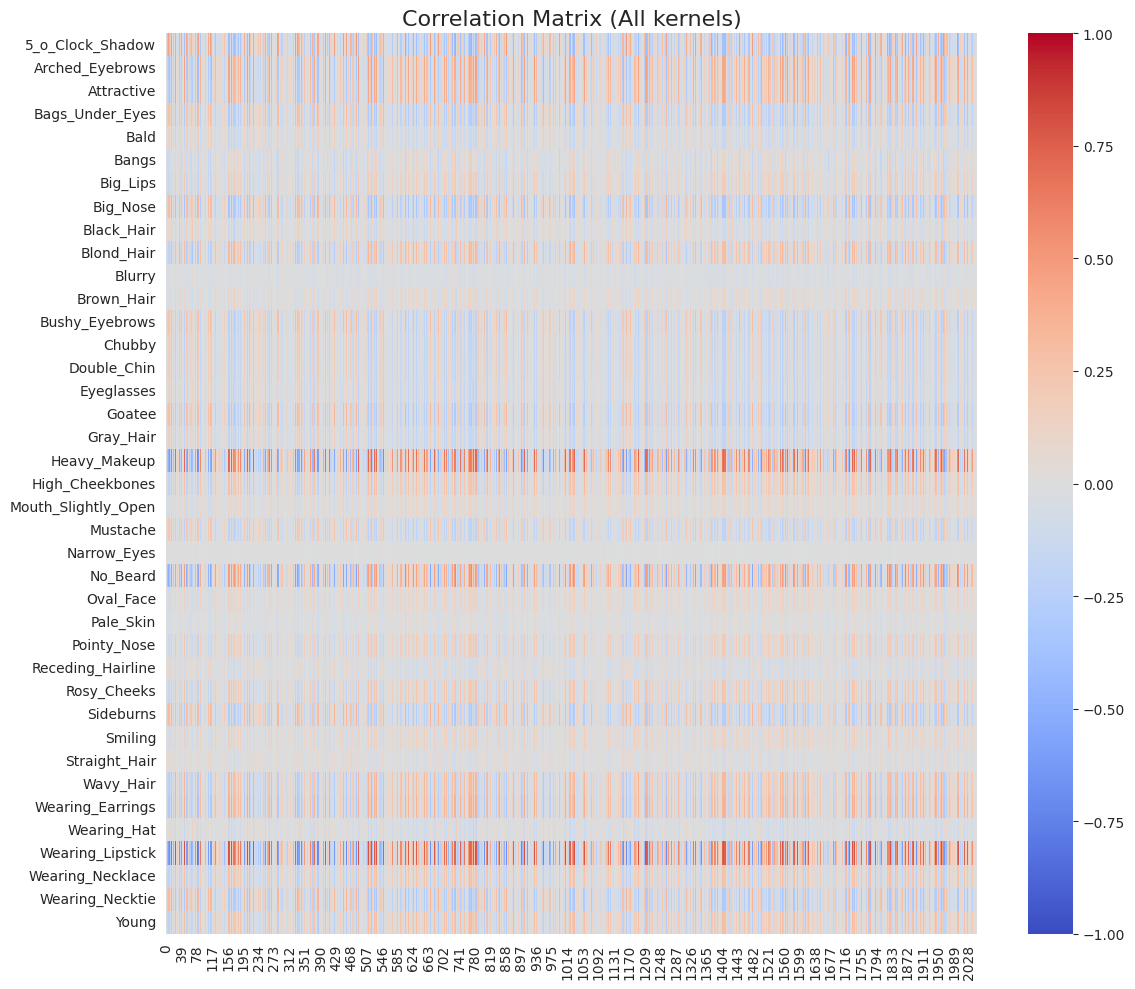

In [28]:
plt.figure(figsize=(12, 10))

axes = sns.heatmap(corr_matrix,
                   cmap='coolwarm',
                   annot=False, vmin=-1, vmax=1,
                   square=False)
#axes.tick_params(labelsize=6, rotation=45)
plt.xticks(rotation=90)
plt.title('Correlation Matrix (All kernels)', fontsize=16)
#plt.show()
plt.tight_layout()
plt.savefig('all-kernel-concept-correlation.pdf')

### First 100 kernels-concept correlation

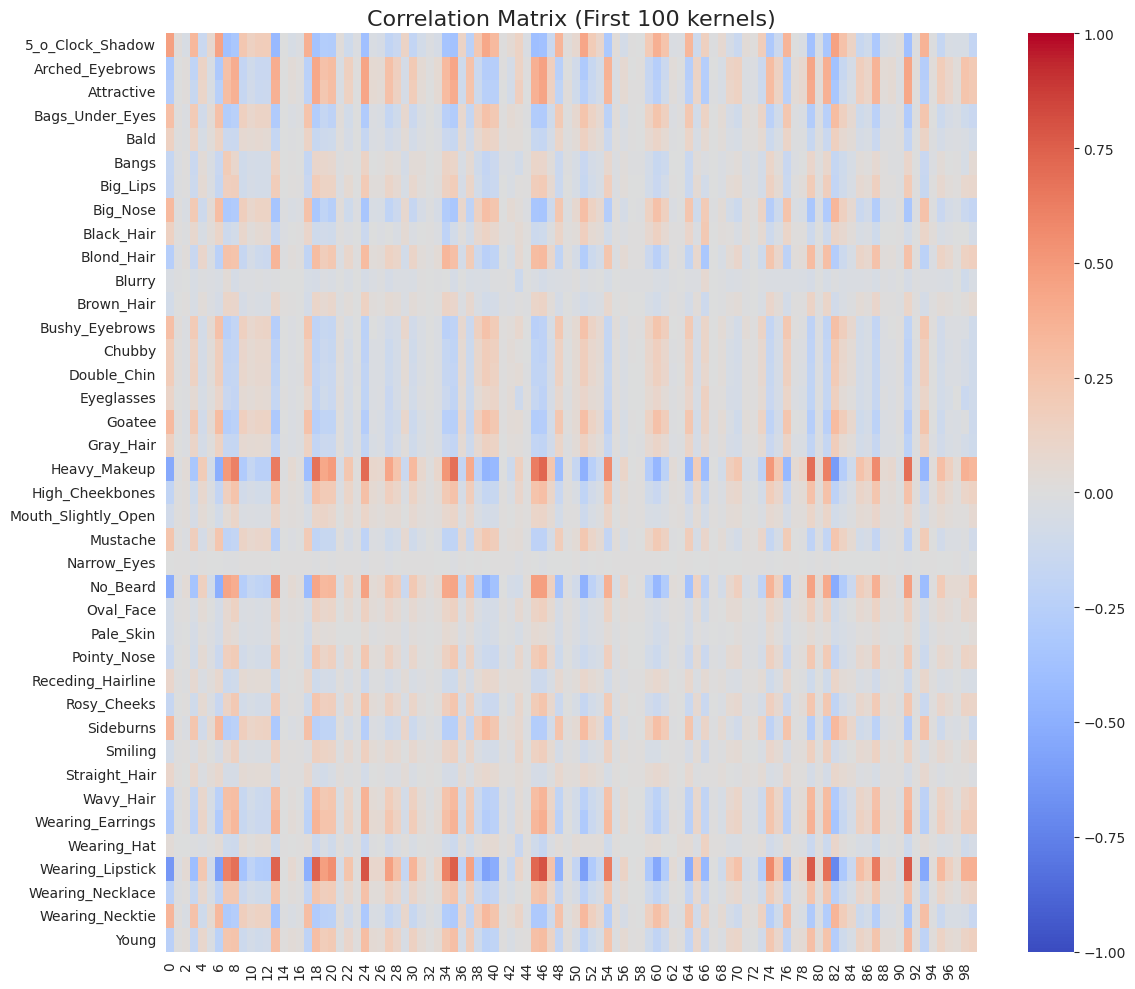

In [29]:
plt.figure(figsize=(12, 10))

axes = sns.heatmap(corr_matrix.iloc[:,:100],
                   cmap='coolwarm',
                   annot=False, vmin=-1, vmax=1,
                   square=False)
#axes.tick_params(labelsize=6, rotation=45)
plt.xticks(rotation=90)
plt.title('Correlation Matrix (First 100 kernels)', fontsize=16)
#plt.show()
plt.tight_layout()
plt.savefig('first_100-kernel-concept-correlation.pdf')

### Top-1 kernel-concept correlated (kernel polisematicy analysis)

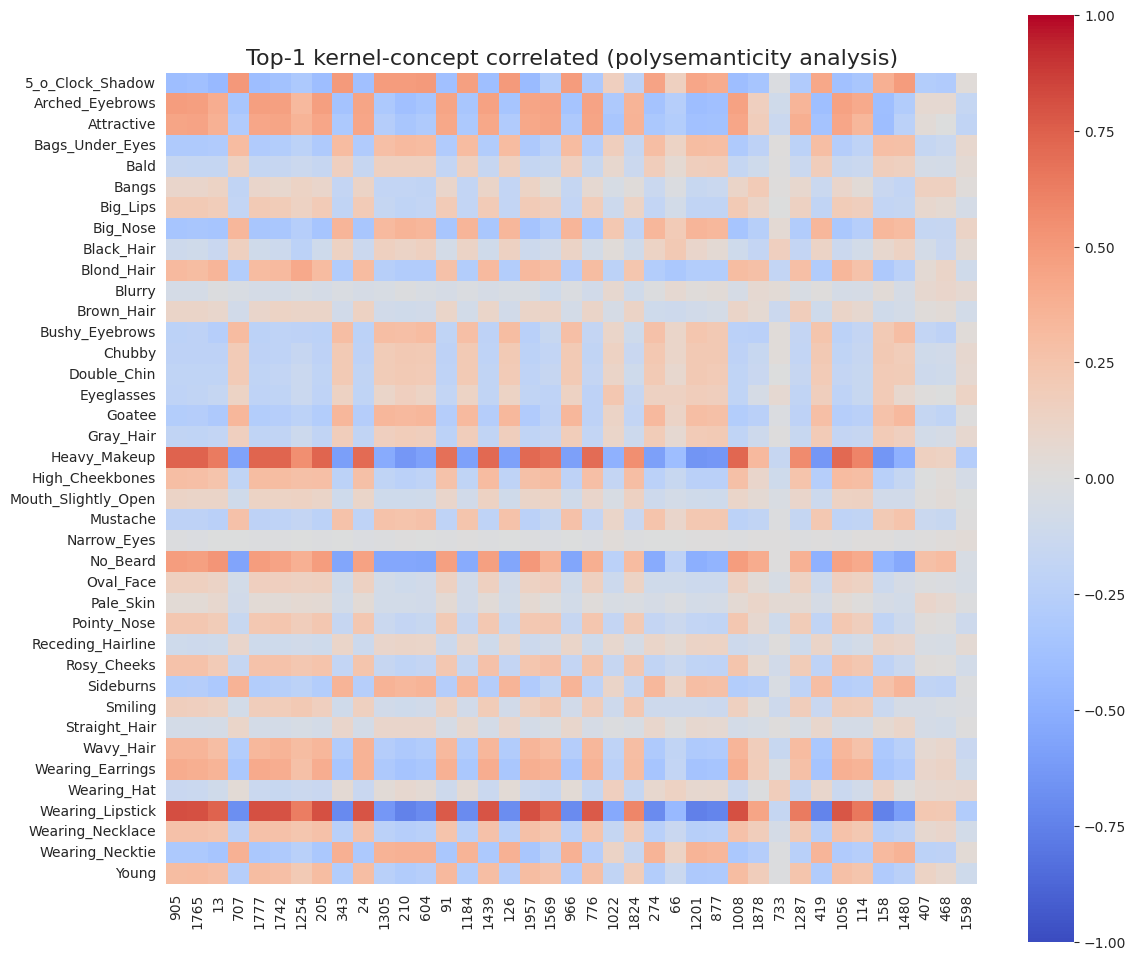

In [30]:
cols = [v[0] for k, v in df_kernel_concepts.items()]

top_corr = corr_matrix.loc[:,cols]

plt.figure(figsize=(12, 10))

axes = sns.heatmap(top_corr,
                   cmap='coolwarm',
                   annot=False, vmin=-1, vmax=1,
                   square=True)
#axes.tick_params(labelsize=6, rotation=45)
plt.xticks(rotation=90)
plt.title('Top-1 kernel-concept correlated (polysemanticity analysis)', fontsize=16)
#plt.show()
plt.tight_layout()
plt.savefig('top-1-kernel-concept-correlation.pdf')

### Select Top-1 kernels/predictors to use for rule extraction

In [31]:
# Top-1 correlated kernel-concepts are already selected
top_predictors = df_binary_activations
top_predictors

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155947,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
155948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
155949,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [32]:
# Compute MSE with train concept
concepts = list(train_concept_presence.keys())
mse = np.mean((train_concept_presence.values - top_predictors.values) ** 2, axis=0)
#train_concept_presence.values[:,:5].shape
print(f'Per concept MSE: {list(mse)}')
print(f'Per concept MSE: {dict(zip(concepts, mse))}')
print(f'Total MSE: {np.mean(mse)}')

Per concept MSE: [0.119633734, 0.24542324, 0.2854807, 0.24557714, 0.045546357, 0.22766766, 0.31706113, 0.25415677, 0.3060641, 0.16451322, 0.096799634, 0.27811942, 0.1846285, 0.09603016, 0.081551254, 0.100800894, 0.08553969, 0.080012314, 0.1630448, 0.35088587, 0.43243712, 0.06221826, 0.20274317, 0.1554655, 0.3530019, 0.0838725, 0.33290586, 0.13447173, 0.109425396, 0.08060224, 0.39707986, 0.30610898, 0.30969983, 0.23969068, 0.07606877, 0.115491405, 0.19459318, 0.1097909, 0.24716738]
Per concept MSE: {'5_o_Clock_Shadow': 0.119633734, 'Arched_Eyebrows': 0.24542324, 'Attractive': 0.2854807, 'Bags_Under_Eyes': 0.24557714, 'Bald': 0.045546357, 'Bangs': 0.22766766, 'Big_Lips': 0.31706113, 'Big_Nose': 0.25415677, 'Black_Hair': 0.3060641, 'Blond_Hair': 0.16451322, 'Blurry': 0.096799634, 'Brown_Hair': 0.27811942, 'Bushy_Eyebrows': 0.1846285, 'Chubby': 0.09603016, 'Double_Chin': 0.081551254, 'Eyeglasses': 0.100800894, 'Goatee': 0.08553969, 'Gray_Hair': 0.080012314, 'Heavy_Makeup': 0.1630448, 'High

In [33]:
#train_concept_presence[df_kernel_concepts.keys()]

### Plot kernel norms distributions (expected bimodal distributions)

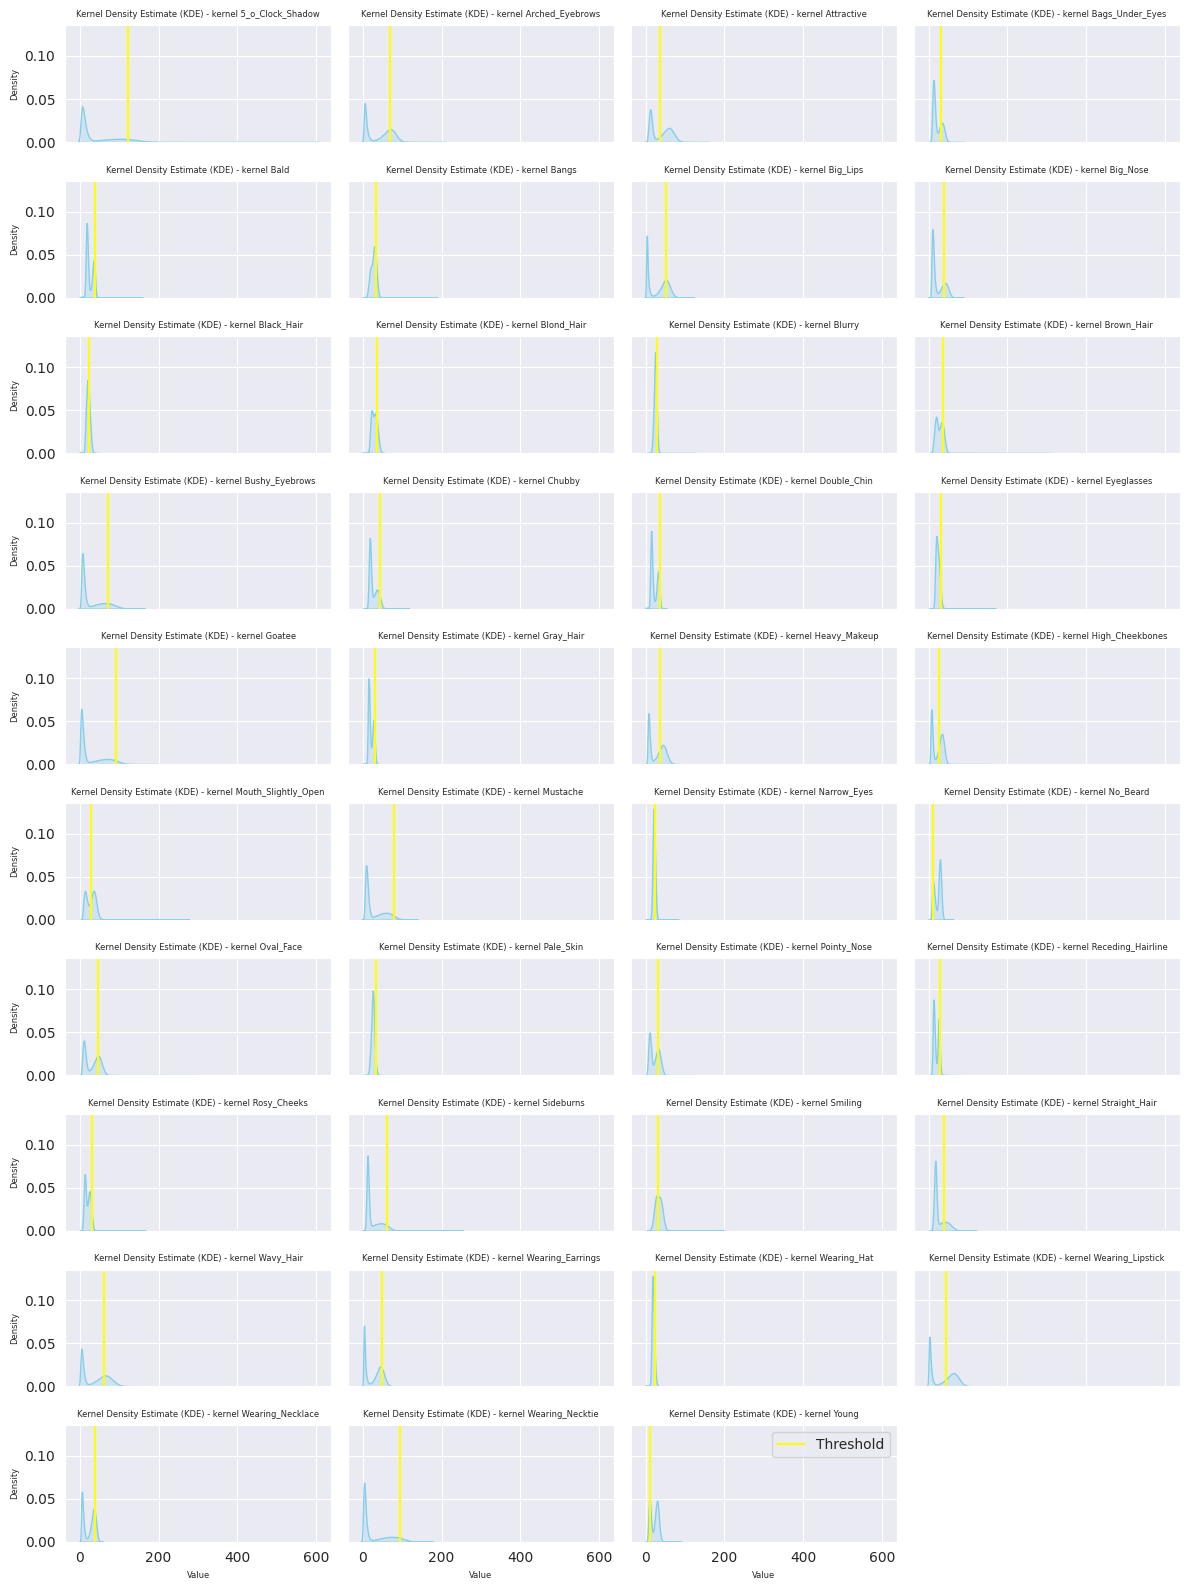

In [34]:
#cols = [v[0] for k, v in df_kernel_concepts.items()]
cols = train_concept_presence.columns
all_kernel_norms = top_norm_predictors_named #torch.cat(kernel_norms_list, dim=0)

fig, axes = plt.subplots(nrows=10, ncols=4, sharex=True, sharey=True, figsize=(12, 16))

#print(f'Kernels: {cols}')

for i, (col, th) in enumerate(zip(cols, eric.kernel_thresholds)):
    k = all_kernel_norms[col]#.cpu().numpy()
    sns.kdeplot(k, bw_adjust=0.5, fill=True, color='skyblue', ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Kernel Density Estimate (KDE) - kernel {col}', fontsize=6)
    axes[i//4, i%4].set_xlabel('Value', fontsize=6)
    axes[i//4, i%4].set_ylabel('Density', fontsize=6)
    axes[i//4, i%4].axvline(th, color='yellow', label='Threshold')

fig.delaxes(axes[-1, -1])
plt.legend()
plt.tight_layout()
plt.savefig('kernel_density.pdf')

In [35]:
def _extract_rules(binary_activations, labels_list, test_binary_activations, test_labels_list, tree_max_depth=5):
        """
        Extract symbolic rules using ERIC.
        """

        all_binary_activations = binary_activations
        all_labels = labels_list

        all_labels = torch.cat(all_labels)

        test_all_binary_activations = test_binary_activations
        test_all_labels = test_labels_list

        test_all_labels = torch.cat(test_all_labels)

        rules = eric.extract_rules(
            all_binary_activations,
            all_labels,
            test_all_binary_activations,
            test_all_labels,
            max_depth=tree_max_depth
        )

        return rules

        '''# Extract rules
        try:
            rules = eric.extract_rules(all_binary_activations, all_labels, max_depth=3)

            # Check if rules were extracted
            if not rules:
                print("Warning: No rules extracted. Creating default rules.")
                default_rule = {
                    'antecedent': [],  # Empty antecedent (always true)
                    'consequent': 1  # Default to class 1
                }
                rules = [default_rule]

            # Analyze which kernels correspond to which components
            useful_kernels = set()
            for rule in rules:
                for sign, kernel_idx in rule['antecedent']:
                    useful_kernels.add(kernel_idx)

            # If no useful kernels found, add some defaults
            if not useful_kernels:
                useful_kernels = set(range(min(10, all_kernel_norms.shape[1])))
        except Exception as e:
            print(f"Error extracting rules: {e}")
            print("Creating default rules...")

            # Create simple default rules using the first few kernels
            num_kernels = min(5, all_kernel_norms.shape[1])
            rules = []

            # Create one simple rule for each class
            for class_id in range(NUM_CLASSES):
                rule = {
                    'antecedent': [(1, 0)],  # Positive literal for first kernel
                    'consequent': class_id
                }
                rules.append(rule)

            useful_kernels = set(range(num_kernels))'''


In [36]:
# Extract top predictors (test set)
# Select top predictors
cols = [v[0] for k, v in df_kernel_concepts.items()]

# Prepare test data
test_all_kernel_norms = torch.cat(test_kernel_norms_list, dim=0)
top_test_norm_predictors = pd.DataFrame(test_all_kernel_norms.numpy()).loc[:,cols]

# Rename column and order them according to train concept percentiles table
test_top_norm_predictors_named = top_test_norm_predictors.rename(columns=kernel_concept_mapping, inplace=False)[list(train_concept_percentiles.keys())]
test_top_norm_predictors = test_top_norm_predictors_named.rename(columns=concept_kernel_mapping, inplace=False)

# Create the tensor for ERIC computations
test_kernel_norms_list = torch.tensor(test_top_norm_predictors.values)

# Binarize kernel norms
print("Binarizing kernel norms...")
test_all_binary_activations = eric.binarize_kernel_activations(test_kernel_norms_list)
test_df_binary_activations = pd.DataFrame(test_all_binary_activations.numpy())

test_top_predictors = test_df_binary_activations
test_top_predictors

Binarizing kernel norms...


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19071,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19072,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19073,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19074,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
# Extract top predictors (test set - drift)
# Select top predictors
cols = [v[0] for k, v in df_kernel_concepts.items()]

# Prepare test data
test_drift_all_kernel_norms = torch.cat(test_drift_kernel_norms_list, dim=0)
top_test_drift_norm_predictors = pd.DataFrame(test_drift_all_kernel_norms.numpy()).loc[:,cols]

# Rename column and order them according to train concept percentiles table
test_drift_top_norm_predictors_named = top_test_drift_norm_predictors.rename(columns=kernel_concept_mapping, inplace=False)[list(train_concept_percentiles.keys())]
test_drift_top_norm_predictors = test_drift_top_norm_predictors_named.rename(columns=concept_kernel_mapping, inplace=False)

# Create the tensor for ERIC computations
test_drift_kernel_norms_list = torch.tensor(test_drift_top_norm_predictors.values)

# Binarize kernel norms
print("Binarizing kernel norms...")
test_drift_all_binary_activations = eric.binarize_kernel_activations(test_drift_kernel_norms_list)
test_drift_df_binary_activations = pd.DataFrame(test_drift_all_binary_activations.numpy())

test_drift_top_predictors = test_drift_df_binary_activations
test_drift_top_predictors

Binarizing kernel norms...


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
# Compute MSE with test concept (no drift)
concepts_test = list(test_nodrift_concept_presence.keys())
mse = np.mean((test_nodrift_concept_presence.values - test_top_predictors.values) ** 2, axis=0)
#train_concept_presence.values[:,:5].shape
print(f'Per concept MSE: {list(mse)}')
print(f'Per concept MSE: {dict(zip(concepts_test, mse))}')
print(f'Total MSE: {np.mean(mse)}')

Per concept MSE: [0.11999371, 0.24769343, 0.3005347, 0.25246382, 0.04434892, 0.22069617, 0.2952401, 0.26169008, 0.29607883, 0.17047599, 0.09210526, 0.30352277, 0.17608513, 0.09970643, 0.080729716, 0.107360035, 0.09283917, 0.08539526, 0.1606731, 0.361082, 0.43782765, 0.07150346, 0.16832669, 0.15480185, 0.35431957, 0.080467604, 0.33350807, 0.13173622, 0.11695324, 0.09058503, 0.40233803, 0.29235688, 0.30357516, 0.24491508, 0.07134619, 0.11946949, 0.19574334, 0.118211366, 0.2708115]
Per concept MSE: {'5_o_Clock_Shadow': 0.11999371, 'Arched_Eyebrows': 0.24769343, 'Attractive': 0.3005347, 'Bags_Under_Eyes': 0.25246382, 'Bald': 0.04434892, 'Bangs': 0.22069617, 'Big_Lips': 0.2952401, 'Big_Nose': 0.26169008, 'Black_Hair': 0.29607883, 'Blond_Hair': 0.17047599, 'Blurry': 0.09210526, 'Brown_Hair': 0.30352277, 'Bushy_Eyebrows': 0.17608513, 'Chubby': 0.09970643, 'Double_Chin': 0.080729716, 'Eyeglasses': 0.107360035, 'Goatee': 0.09283917, 'Gray_Hair': 0.08539526, 'Heavy_Makeup': 0.1606731, 'High_Chee

In [39]:
# Compute MSE with test concept (drift)
concepts_test_drift = list(test_drift_concept_presence.keys())
mse = np.mean((test_drift_concept_presence.values - test_drift_top_predictors.values) ** 2, axis=0)
#train_concept_presence.values[:,:5].shape
print(f'Per concept MSE: {list(mse)}')
print(f'Per concept MSE: {dict(zip(concepts_test_drift, mse))}')
print(f'Total MSE: {np.mean(mse)}')

Per concept MSE: [0.20904374, 0.20904374, 0.15641215, 0.3876946, 0.11415864, 0.08673091, 0.57227576, 0.49147516, 0.5129726, 0.023721276, 0.0948851, 0.053372867, 0.26464048, 0.30911785, 0.17272054, 0.306894, 0.31060046, 0.06671608, 0.031134173, 0.44255003, 0.5366939, 0.25129727, 0.3276501, 0.48332098, 0.3358043, 0.09340252, 0.05707932, 0.32987398, 0.0037064492, 0.111934766, 0.44180876, 0.3587843, 0.0726464, 0.99777615, 0.2624166, 0.0363232, 0.12527798, 0.13046701, 0.39955524]
Per concept MSE: {'5_o_Clock_Shadow': 0.20904374, 'Arched_Eyebrows': 0.20904374, 'Attractive': 0.15641215, 'Bags_Under_Eyes': 0.3876946, 'Bald': 0.11415864, 'Bangs': 0.08673091, 'Big_Lips': 0.57227576, 'Big_Nose': 0.49147516, 'Black_Hair': 0.5129726, 'Blond_Hair': 0.023721276, 'Blurry': 0.0948851, 'Brown_Hair': 0.053372867, 'Bushy_Eyebrows': 0.26464048, 'Chubby': 0.30911785, 'Double_Chin': 0.17272054, 'Eyeglasses': 0.306894, 'Goatee': 0.31060046, 'Gray_Hair': 0.06671608, 'Heavy_Makeup': 0.031134173, 'High_Cheekbone

Best fidelity: 0.9747100050656937
Best depth: 17


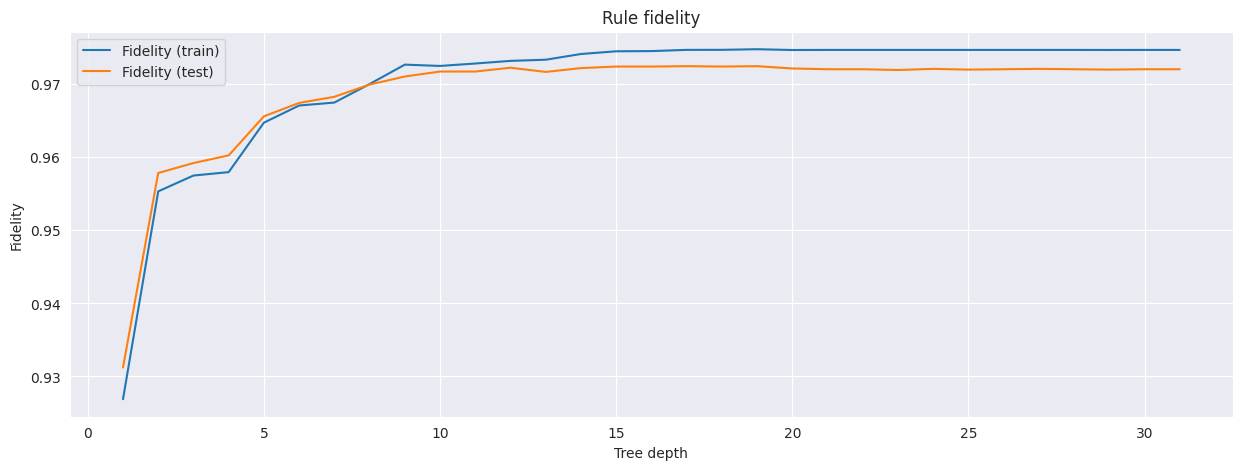

In [40]:
# Find optimal tree depth
tree_depths = range(1, 32)
rule_fidelities = []
rule_fidelities_test = []
best_depth, best_fidelity = 0, 0

for depth in tree_depths:
    _ = _extract_rules(
        torch.tensor(top_predictors.values),
        predictions_list,
        torch.tensor(test_top_predictors.values),
        test_predictions_list,
        tree_max_depth=depth
    )
    rule_fidelities.append(eric.rule_fidelity)
    rule_fidelities_test.append(eric.rule_fidelity_test)

    if eric.rule_fidelity - best_fidelity > 0.0004:
        best_fidelity = eric.rule_fidelity
        best_depth = depth

print("Best fidelity:", best_fidelity)
print("Best depth:", best_depth)

plt.figure(figsize=(15,5))
plt.plot(tree_depths, rule_fidelities, label="Fidelity (train)")
plt.plot(tree_depths, rule_fidelities_test, label="Fidelity (test)")
plt.xlabel("Tree depth")
plt.ylabel("Fidelity")
plt.title("Rule fidelity")
plt.legend()
plt.grid(True)
plt.savefig('rule_fidelity.pdf')

In [41]:
# Extract and analyze symbolic rules
print(f"Extracting symbolic rules...(using best_max_depth={best_depth})")
# To approximate the FC classifier, use the model prediction on the training set instead of labels_list
rules = _extract_rules(
    torch.tensor(top_predictors.values),
    predictions_list,
    torch.tensor(test_top_predictors.values),
    test_predictions_list,
    tree_max_depth=5
)
rules
#kernel_thresholds

Extracting symbolic rules...(using best_max_depth=17)


[{'antecedent': [(-1, 2), (-1, 5), (-1, 7), (-1, 38), (-1, 32)],
  'consequent': 1,
  'confidence': 0.9994900772844466,
  'samples': 0},
 {'antecedent': [(-1, 2), (-1, 5), (-1, 7), (-1, 38), (1, 32)],
  'consequent': 0,
  'confidence': 1.0,
  'samples': 1},
 {'antecedent': [(-1, 2), (-1, 5), (-1, 7), (1, 38), (-1, 20)],
  'consequent': 1,
  'confidence': 0.8525675427067123,
  'samples': 1},
 {'antecedent': [(-1, 2), (-1, 5), (-1, 7), (1, 38), (1, 20)],
  'consequent': 0,
  'confidence': 0.5712889762975847,
  'samples': 0},
 {'antecedent': [(-1, 2), (-1, 5), (1, 7), (-1, 20)],
  'consequent': 1,
  'confidence': 1.0,
  'samples': 1},
 {'antecedent': [(-1, 2), (-1, 5), (1, 7), (1, 20), (-1, 1)],
  'consequent': 1,
  'confidence': 0.9984334936288513,
  'samples': 1},
 {'antecedent': [(-1, 2), (-1, 5), (1, 7), (1, 20), (1, 1)],
  'consequent': 1,
  'confidence': 0.6027854903142654,
  'samples': 1},
 {'antecedent': [(-1, 2), (1, 5), (-1, 38), (-1, 1), (-1, 15)],
  'consequent': 1,
  'confide

In [42]:
for rule in rules:
    string_rules = eric.rule_to_string(rule)
    print(string_rules)

¬kernel_2 ∧ ¬kernel_5 ∧ ¬kernel_7 ∧ ¬kernel_38 ∧ ¬kernel_32 → Class_1 (conf=1.00)
¬kernel_2 ∧ ¬kernel_5 ∧ ¬kernel_7 ∧ ¬kernel_38 ∧ kernel_32 → Class_0 (conf=1.00)
¬kernel_2 ∧ ¬kernel_5 ∧ ¬kernel_7 ∧ kernel_38 ∧ ¬kernel_20 → Class_1 (conf=0.85)
¬kernel_2 ∧ ¬kernel_5 ∧ ¬kernel_7 ∧ kernel_38 ∧ kernel_20 → Class_0 (conf=0.57)
¬kernel_2 ∧ ¬kernel_5 ∧ kernel_7 ∧ ¬kernel_20 → Class_1 (conf=1.00)
¬kernel_2 ∧ ¬kernel_5 ∧ kernel_7 ∧ kernel_20 ∧ ¬kernel_1 → Class_1 (conf=1.00)
¬kernel_2 ∧ ¬kernel_5 ∧ kernel_7 ∧ kernel_20 ∧ kernel_1 → Class_1 (conf=0.60)
¬kernel_2 ∧ kernel_5 ∧ ¬kernel_38 ∧ ¬kernel_1 ∧ ¬kernel_15 → Class_1 (conf=0.95)
¬kernel_2 ∧ kernel_5 ∧ ¬kernel_38 ∧ ¬kernel_1 ∧ kernel_15 → Class_1 (conf=1.00)
¬kernel_2 ∧ kernel_5 ∧ ¬kernel_38 ∧ kernel_1 ∧ ¬kernel_16 → Class_0 (conf=0.90)
¬kernel_2 ∧ kernel_5 ∧ ¬kernel_38 ∧ kernel_1 ∧ kernel_16 → Class_1 (conf=0.84)
¬kernel_2 ∧ kernel_5 ∧ kernel_38 ∧ ¬kernel_15 ∧ ¬kernel_22 → Class_0 (conf=0.89)
¬kernel_2 ∧ kernel_5 ∧ kernel_38 ∧ ¬kernel_15 ∧ ke

In [43]:
#names = list(df_kernel_concepts.keys())
names = list(train_concept_presence.columns)

for rule in rules:
    string_rules = eric.rule_to_string(rule, names)
    print(string_rules)

¬Attractive ∧ ¬Bangs ∧ ¬Big_Nose ∧ ¬Young ∧ ¬Wavy_Hair → Class_1 (conf=1.00)
¬Attractive ∧ ¬Bangs ∧ ¬Big_Nose ∧ ¬Young ∧ Wavy_Hair → Class_0 (conf=1.00)
¬Attractive ∧ ¬Bangs ∧ ¬Big_Nose ∧ Young ∧ ¬Mouth_Slightly_Open → Class_1 (conf=0.85)
¬Attractive ∧ ¬Bangs ∧ ¬Big_Nose ∧ Young ∧ Mouth_Slightly_Open → Class_0 (conf=0.57)
¬Attractive ∧ ¬Bangs ∧ Big_Nose ∧ ¬Mouth_Slightly_Open → Class_1 (conf=1.00)
¬Attractive ∧ ¬Bangs ∧ Big_Nose ∧ Mouth_Slightly_Open ∧ ¬Arched_Eyebrows → Class_1 (conf=1.00)
¬Attractive ∧ ¬Bangs ∧ Big_Nose ∧ Mouth_Slightly_Open ∧ Arched_Eyebrows → Class_1 (conf=0.60)
¬Attractive ∧ Bangs ∧ ¬Young ∧ ¬Arched_Eyebrows ∧ ¬Eyeglasses → Class_1 (conf=0.95)
¬Attractive ∧ Bangs ∧ ¬Young ∧ ¬Arched_Eyebrows ∧ Eyeglasses → Class_1 (conf=1.00)
¬Attractive ∧ Bangs ∧ ¬Young ∧ Arched_Eyebrows ∧ ¬Goatee → Class_0 (conf=0.90)
¬Attractive ∧ Bangs ∧ ¬Young ∧ Arched_Eyebrows ∧ Goatee → Class_1 (conf=0.84)
¬Attractive ∧ Bangs ∧ Young ∧ ¬Eyeglasses ∧ ¬Narrow_Eyes → Class_0 (conf=0.89)
¬Attrac

In [44]:
print(f'Rule fidelity (train): {eric.rule_fidelity}')
print(f'Rule fidelity (test): {eric.rule_fidelity_test}')

Rule fidelity (train): 0.9647453366762637
Rule fidelity (test): 0.9656112392535122


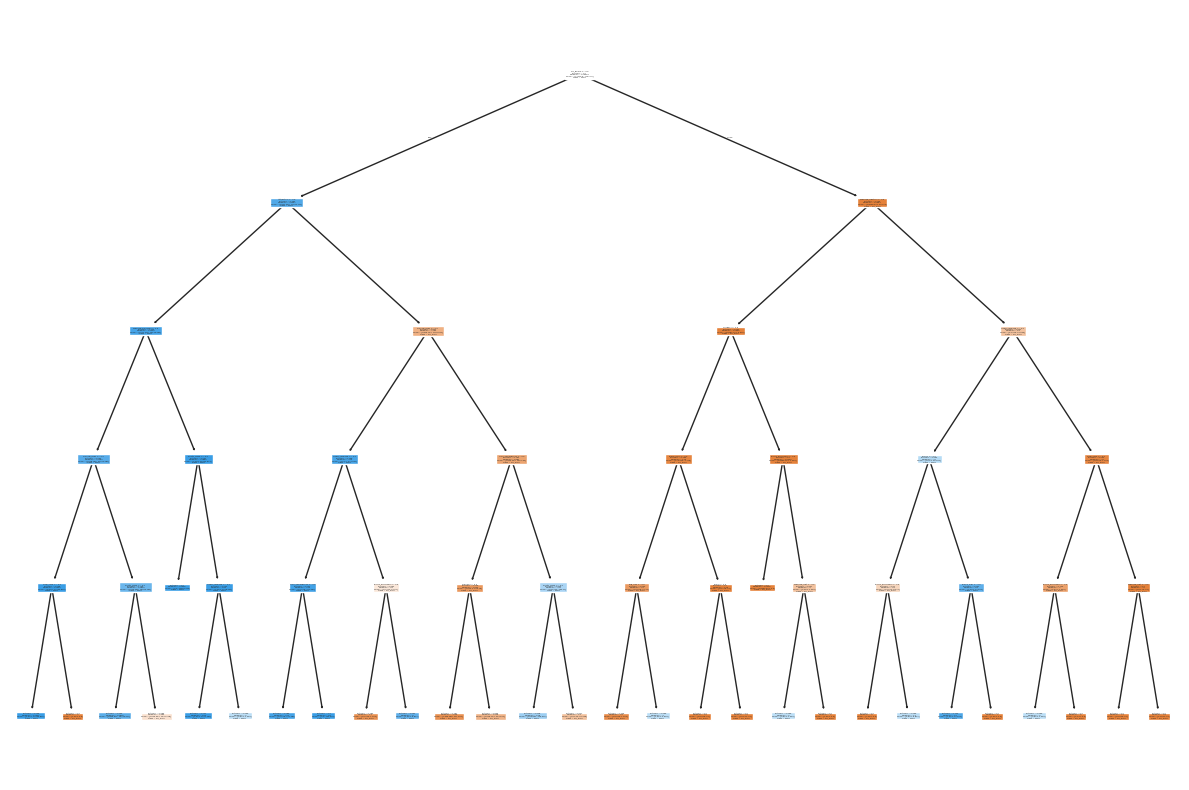

In [45]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(eric.dt, filled=True, feature_names=list(df_kernel_concepts.keys()), class_names=['No_Male', 'Male'])
plt.tight_layout()
plt.savefig('tree.pdf')

### Extract rule satisfied by the image

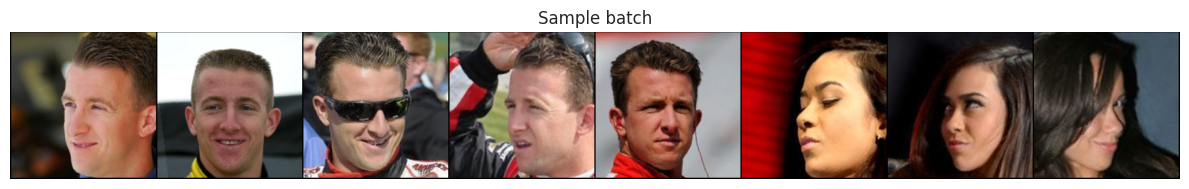

In [46]:
images, labels, _ = next(iter(train_dataloader))

imgs = images[24:32] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=False, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.tight_layout()
plt.savefig('sample.png')

In [47]:
def explain_decision(clf, sample, feature_names, class_names):
    print("Explaining decision:")
    node_indicator = clf.decision_path(sample)
    node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

    final_rule = []
    prediction = None

    for node_id in node_index:
        if clf.tree_.feature[node_id] != -2:
            fname = feature_names[clf.tree_.feature[node_id]]
            threshold_val = clf.tree_.threshold[node_id]
            sample_val = sample.iloc[0, clf.tree_.feature[node_id]]
            op = "<=" if sample_val <= threshold_val else ">"
            print(f"{fname} = {sample_val:.3f} {op} {threshold_val:.3f}")
            final_rule.append(f'¬{fname}' if sample_val <= threshold_val else fname)
        else:
            print(f"Leaf node → predict class: {clf.classes_[np.argmax(clf.tree_.value[node_id])]}")
            prediction = class_names[int(clf.classes_[np.argmax(clf.tree_.value[node_id])])]

    print("Final rule:")
    print(f"{' ∧ '.join(final_rule)} → {prediction}")


In [48]:
#train_concept_presence[df_kernel_concepts.keys()].iloc[[24]]
train_concept_presence.iloc[[25]]

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
print(train_concept_presence.iloc[[31]].values.tolist())
print(top_predictors.iloc[[31]].values.tolist())

[[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]


In [50]:
SAMPLE = 24

explain_decision(eric.dt, top_predictors.iloc[[SAMPLE]], list(train_concept_presence.columns), class_names=['No_Male', 'Male'])

Explaining decision:
Attractive = 0.000 <= 0.500
Bangs = 0.000 <= 0.500
Big_Nose = 0.000 <= 0.500
Young = 1.000 > 0.500
Mouth_Slightly_Open = 0.000 <= 0.500
Leaf node → predict class: 1.0
Final rule:
¬Attractive ∧ ¬Bangs ∧ ¬Big_Nose ∧ Young ∧ ¬Mouth_Slightly_Open → Male
